# A notebook for cumulative sc graphs

In [1]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)
from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [127]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [88]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/relocalisation/infect_label_{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/05/04 03:40:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 4).h5...
[INFO][2023/05/04 03:40:19 PM] Loading tracks/obj_type_1
[INFO][2023/05/04 03:40:19 PM] Loading LBEP/obj_type_1
[INFO][2023/05/04 03:40:19 PM] Loading objects/obj_type_1 (26904, 5) (26904 filtered: None)
[INFO][2023/05/04 03:40:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 4).h5
[INFO][2023/05/04 03:40:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5...
[INFO][2023/05/04 03:40:19 PM] Loading tracks/obj_type_1
[INFO][2023/05/04 03:40:19 PM] Loading LBEP/obj_type_1
[INFO][2023/05/04 03:40:19 PM] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/04 03:40:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5
[INFO][2023/05/04 03:40:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 6).h5...
[INFO][2023/05/04 

[INFO][2023/05/04 03:40:31 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(6, 5).h5...
[INFO][2023/05/04 03:40:31 PM] Loading tracks/obj_type_1
[INFO][2023/05/04 03:40:31 PM] Loading LBEP/obj_type_1
[INFO][2023/05/04 03:40:31 PM] Loading objects/obj_type_1 (30067, 5) (30067 filtered: None)
[INFO][2023/05/04 03:40:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(6, 5).h5
[INFO][2023/05/04 03:40:32 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(6, 6).h5...
[INFO][2023/05/04 03:40:32 PM] Loading tracks/obj_type_1
[INFO][2023/05/04 03:40:32 PM] Loading LBEP/obj_type_1
[INFO][2023/05/04 03:40:32 PM] Loading objects/obj_type_1 (26645, 5) (26645 filtered: None)
[INFO][2023/05/04 03:40:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(6, 6).h5
[INFO][2023/05/04 03:40:32 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(6, 7).h5...
[INFO][2023/05/04 

In [14]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,Infected,area,mean_intensity,orientation,major_axis_length
0,324,0,955.750061,26.453724,0.000000,324,324,5,0,False,169.649216,0.0,38263.0,"(3,) array",-1.410147,296.419403
1,324,1,961.911377,25.325357,0.000000,324,324,5,0,False,194.568069,0.0,52851.0,"(3,) array",-1.535681,386.590546
2,324,2,964.602966,26.337461,0.000000,324,324,5,0,False,219.315338,0.0,52894.0,"(3,) array",-1.499841,330.689148
3,324,3,963.317078,22.161148,0.000000,324,324,5,0,False,179.383804,0.0,50287.0,"(3,) array",-1.503667,379.267853
4,324,4,963.083435,23.526087,0.000000,324,324,5,0,False,180.160614,0.0,43029.0,"(3,) array",-1.380799,330.320404
5,324,5,963.584839,23.606216,0.372394,324,324,5,0,True,NaN,NaN,NaN,"(3,) array",NaN,NaN
6,324,6,965.002197,23.610384,0.000000,324,324,5,0,False,161.264740,0.0,45249.0,"(3,) array",-1.317333,396.892395
7,324,7,957.956482,28.067999,0.000000,324,324,5,0,False,161.996002,0.0,52266.0,"(3,) array",-1.388103,442.716858
8,324,8,958.539185,27.097019,0.000000,324,324,5,0,False,149.430954,0.0,52387.0,"(3,) array",-1.291636,485.450256
9,324,9,962.485535,25.507084,0.000000,324,324,5,0,False,144.363663,0.0,51945.0,"(3,) array",-1.242747,491.030365


In [12]:
track['mean_intensity'][:, 2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00,            nan, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.62225692e-04, 0.00000000e+00, 9.42311672e-05, 1.13695837e-03,
       7.43549681e-05, 7.03293772e-04, 7.59921750e-05, 1.05358218e-03,
       1.15884992e-03, 7.93466461e-04, 1.28242769e-03, 8.29576747e-04,
       8.42874229e-04])

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [16]:
key = (3, 4)

In [18]:
f'{track.ID}.{key[0]}.{key[1]}'

'324.3.4'

In [165]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >34] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
             'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
             'Infection status':track['Infected'],
             'Initial infection status':track['Infected'][0], 
             'Final infection status':track['Infected'][-1], 
             'Area':track['area'], 
             'Intracellular mean Mtb content':track['mean_intensity'][:, 1],
             'Intracellular thresholded Mtb content':track['mean_intensity'][:, 2],
             'Macroph. GFP expression':track['mean_intensity'][:, 0],
             'delta Mtb': [track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2] for i in range(len(track['t']))],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/24 [00:00<?, ?it/s]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,404.540741,17.521969,2038.885334,88.310723,1.0,1.0,0.0,22641.0,354.289642,...,1192.025757,-0.027958,0.748962,0.000000,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
1,1,413.055695,10.114442,2081.800701,50.976787,1.0,1.0,0.0,11588.0,350.977905,...,1376.013428,-0.027958,0.645172,11.286093,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
2,2,382.524567,5.971316,1927.923816,30.095434,0.0,1.0,0.0,15089.0,336.285828,...,958.890137,-0.027958,0.964400,30.810960,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
3,3,387.733215,7.013307,1954.175405,35.347068,0.0,1.0,0.0,16723.0,337.263458,...,984.066406,-0.027958,0.948047,5.311851,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
4,4,397.491516,8.356998,2003.357241,42.119272,0.0,1.0,0.0,24029.0,337.026093,...,1016.706482,-0.027958,0.951076,9.850378,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452417,70,740.603149,275.762604,3732.639873,1389.843523,1.0,0.0,0.0,104937.0,363.433960,...,1183.976929,0.000000,0.797845,1.546608,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452418,71,742.959290,295.042786,3744.514819,1487.015640,1.0,0.0,0.0,59328.0,360.162720,...,1099.063599,0.000000,0.497413,19.423615,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452419,72,743.820374,298.072815,3748.854683,1502.286987,1.0,0.0,0.0,71791.0,365.228577,...,1428.077393,0.000000,0.820148,3.150007,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452420,73,744.693665,296.888824,3753.256069,1496.319675,0.0,0.0,0.0,66184.0,358.656128,...,1097.713745,0.000000,0.592617,1.471214,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9


# Create a separate df for "survivor" tracks

i.e. all tracks that last the length of the time lapse

In [91]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tracks_dict.keys():
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
             'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
             'Infection status':track['Infected'],
             'Initial infection status':track['Infected'][0], 
             'Area':track['area'], 
             'Intracellular mean Mtb content':track['mean_intensity'][:, 1],
             'Intracellular thresholded Mtb content':track['mean_intensity'][:, 2],
             'Macroph. GFP expression':track['mean_intensity'][:, 0],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
full_len_df = pd.concat(dfs, ignore_index=True)
full_len_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Area,Intracellular mean Mtb content,Intracellular thresholded Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,1170.369019,14.416864,5898.659854,72.660997,0.0,19575.0,335.097412,0.000000,951.512085,0.808996,0.000000,RD1,CTRL,EC0,362,"(3, 4)",362.3.4
1,1,1173.228638,15.141645,5913.072334,76.313893,0.0,27057.0,333.451996,0.000000,856.020874,0.842797,2.950039,RD1,CTRL,EC0,362,"(3, 4)",362.3.4
2,2,1174.987549,14.820678,5921.937246,74.696216,0.0,23948.0,333.498169,0.000000,900.753479,0.717155,1.787957,RD1,CTRL,EC0,362,"(3, 4)",362.3.4
3,3,1175.758301,12.642924,5925.821836,63.720339,0.0,19960.0,332.029816,0.000000,866.517883,0.741340,2.310123,RD1,CTRL,EC0,362,"(3, 4)",362.3.4
4,4,1180.933838,10.359253,5951.906543,52.210635,0.0,13934.0,330.647827,0.000000,825.904846,0.758527,5.656973,RD1,CTRL,EC0,362,"(3, 4)",362.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113845,70,560.176086,1177.600464,2823.287476,5935.106338,1.0,76963.0,369.289581,0.006523,1631.324219,0.698173,3.138812,WT,BDQ,EC99,174,"(6, 9)",174.6.9
113846,71,556.835510,1178.447144,2806.450972,5939.373604,1.0,73237.0,367.541840,0.006199,1573.362549,0.716424,3.446203,WT,BDQ,EC99,174,"(6, 9)",174.6.9
113847,72,560.304932,1178.903320,2823.936855,5941.672734,1.0,77882.0,366.891022,0.006086,1442.828369,0.791392,3.499283,WT,BDQ,EC99,174,"(6, 9)",174.6.9
113848,73,565.476746,1180.857056,2850.002798,5951.519561,1.0,70011.0,367.490204,0.006999,1384.271851,0.821893,5.528539,WT,BDQ,EC99,174,"(6, 9)",174.6.9


# Plotting the effect of antibiotics

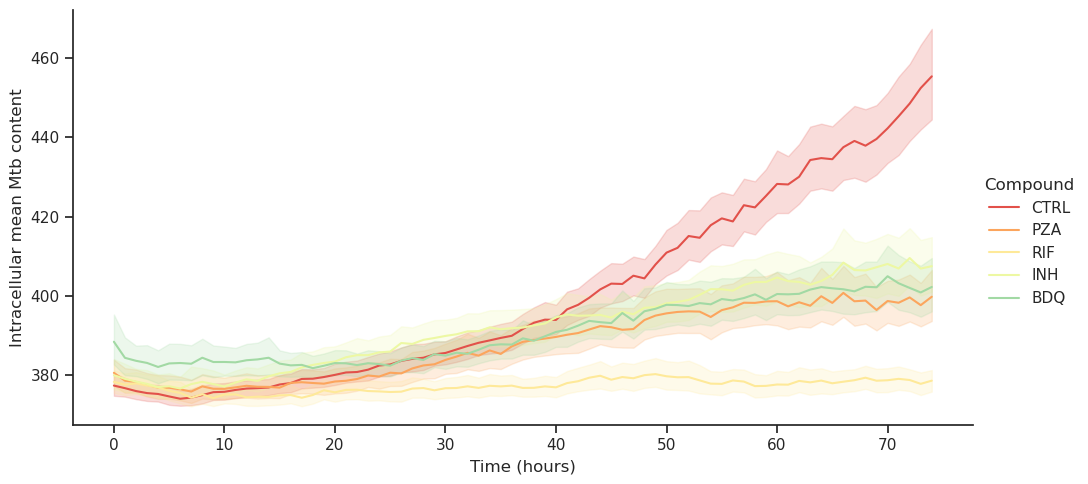

In [51]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular mean Mtb content', 
            hue = 'Compound', kind = 'line',
            aspect = 2,
           )

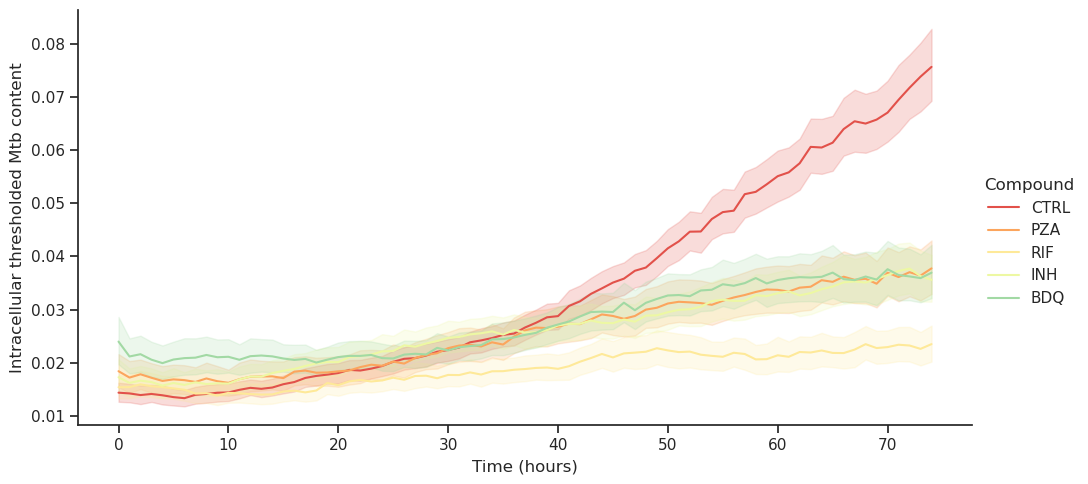

In [52]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Compound', kind = 'line',
            aspect = 2,
           )

In [54]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [55]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

# Output

In [57]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'
os.makedirs(output_dir, exist_ok = True)

# Effect of ATB on WT

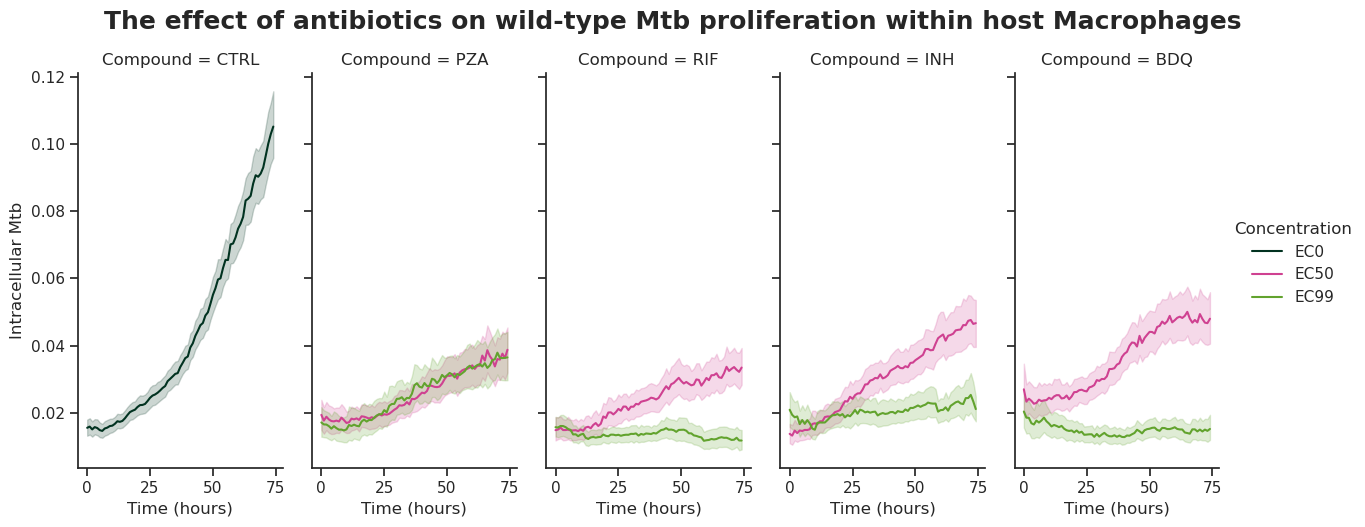

In [58]:
g = sns.relplot(data = df[df['Strain'] != 'RD1'], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

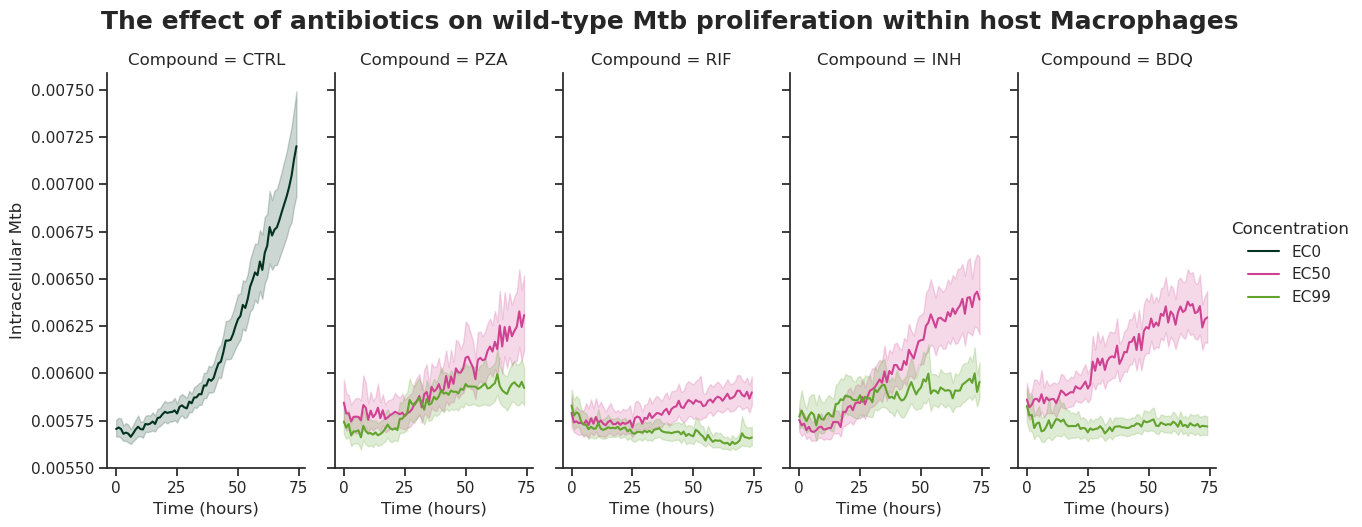

In [64]:
g = sns.relplot(data = df[df['Strain'] != 'RD1'], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/ATB_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)

# Isolating just the control and ideal ATB case

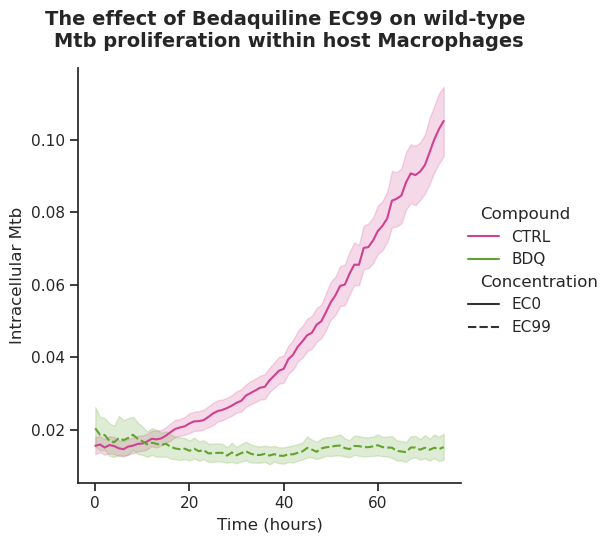

In [60]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') &
                          (df['Compound'] == 'CTRL') |
                          (df['Compound'] == 'BDQ') &
                          (df['Concentration'] == 'EC99')], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Concentration',
            hue= 'Compound',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC99 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_CTRL_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

## Focusing on BDQ

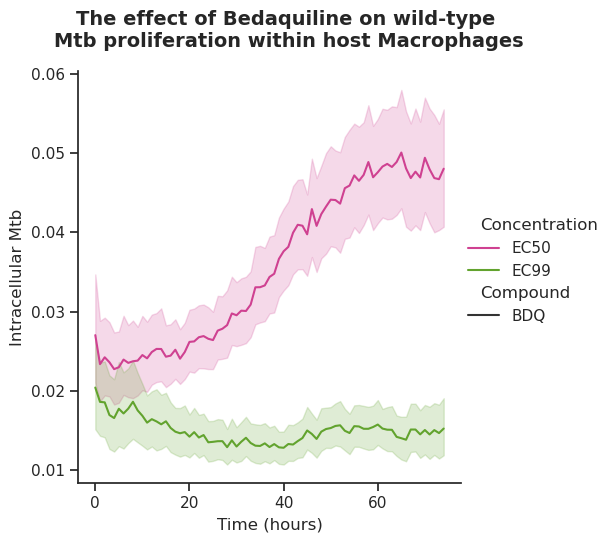

In [61]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

### Checking difference (if any) between repeat experiments

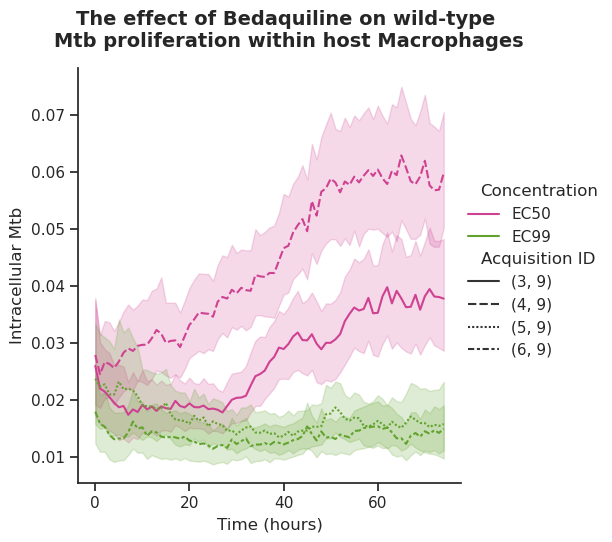

In [62]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_effect_WT_Mtb_separated_by_expt.png'), bbox_inches = 'tight', dpi = 314)

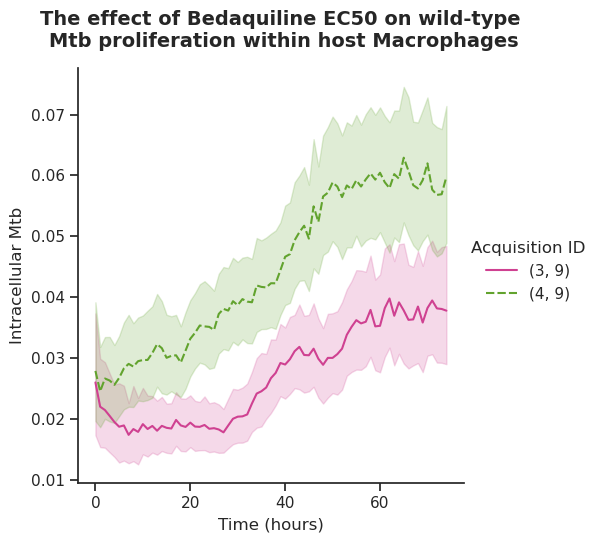

In [63]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ') &
               (df['Concentration'] == 'EC50')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_EC50_effect_WT_Mtb_separated_by_expt.png'), bbox_inches = 'tight', dpi = 314)

# What proportion of cells are positive?

In [134]:
N_cell_df = list()
for acq_ID in df['Acquisition ID'].unique():
    expt_df = df[df['Acquisition ID'] == acq_ID]
    N_cells = list()
    N_cells_infected = list()
    N_cells_uninfected = list()
    N_cell_dict[acq_ID] = dict()
    info = assay_layout.loc[acq_ID]
    for t in range(0, 75):
        N_cells.append(len(expt_df[expt_df['Time (hours)'] == t]))
        N_cells_infected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                            & (expt_df['Infection status'] == 1)]))
        N_cells_uninfected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                            & (expt_df['Infection status'] != 1)]))
        
    d = {'Time (hours)':list(range(0, 75)), 
         'N_cells':N_cells,
         'N_cells_infected':N_cells_infected,
         'N_cells_uninfected':N_cells_uninfected, 
         'Acquisition ID': [acq_ID for i in range(0,75)],
         'Strain':[info['Strain'] for i in range(0, 75)], 
         'Compound':[info['Compound'] for i in range(0, 75)], 
         'Concentration':[info['ConcentrationEC'] for i in  range(0, 75)], }
    N_cell_df.append(pd.DataFrame(d))
### concat single track dfs into big df
N_cell_df = pd.concat(N_cell_df, ignore_index=True)
N_cell_df

,Time (hours),N_cells,N_cells_infected,N_cells_uninfected,Acquisition ID,Strain,Compound,Concentration
0,0,168,74,94,"(3, 4)",RD1,CTRL,EC0
1,1,176,75,101,"(3, 4)",RD1,CTRL,EC0
2,2,184,71,113,"(3, 4)",RD1,CTRL,EC0
3,3,189,69,120,"(3, 4)",RD1,CTRL,EC0
4,4,194,72,122,"(3, 4)",RD1,CTRL,EC0
...,...,...,...,...,...,...,...,...
1795,70,173,124,49,"(6, 9)",WT,BDQ,EC99
1796,71,170,119,51,"(6, 9)",WT,BDQ,EC99
1797,72,161,106,55,"(6, 9)",WT,BDQ,EC99
1798,73,159,109,50,"(6, 9)",WT,BDQ,EC99


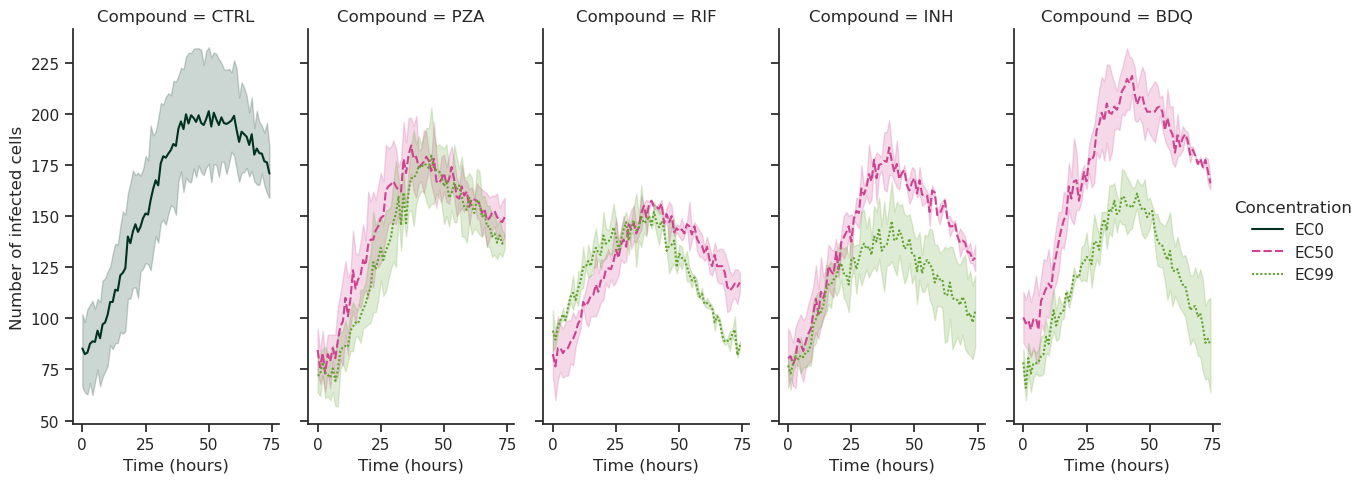

In [144]:
g = sns.relplot(data = N_cell_df[N_cell_df['Strain'] == 'WT'],
                x = 'Time (hours)', 
                y = 'N_cells_infected', 
                style= 'Concentration',
                hue= 'Concentration',
                col= 'Compound',
                kind = 'line',
                aspect = 0.5,
                palette=colors
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Number of infected cells")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
# plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.08)
# plt.savefig(os.path.join(output_dir, 'BDQ_EC50_effect_WT_Mtb_separated_by_expt.png'), bbox_inches = 'tight', dpi = 314)

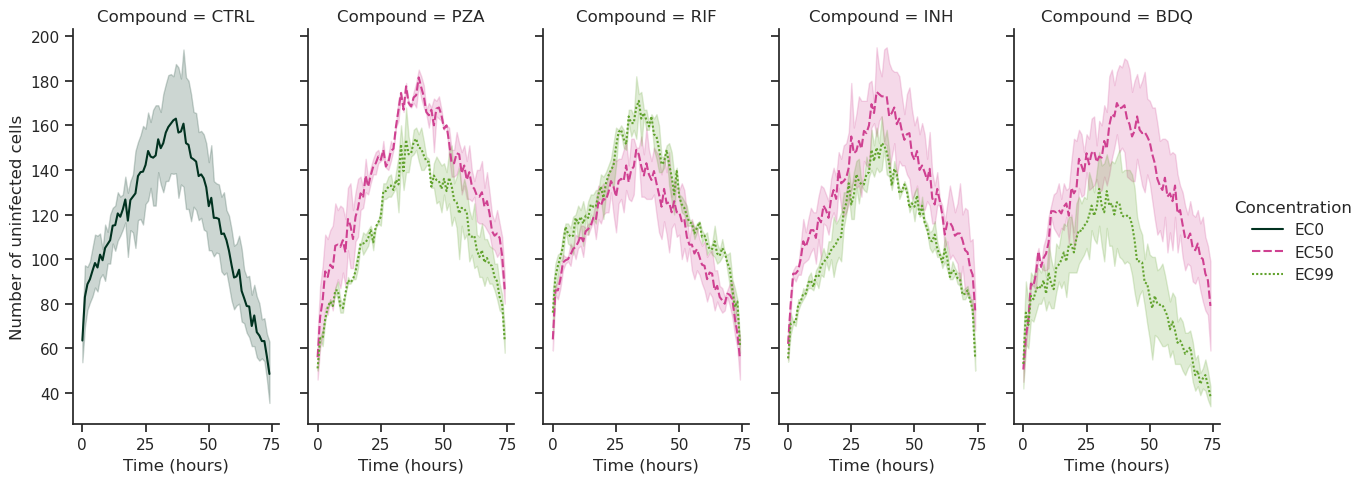

In [147]:
g = sns.relplot(data = N_cell_df[N_cell_df['Strain'] == 'WT'],
                x = 'Time (hours)', 
                y = 'N_cells_uninfected', 
                style= 'Concentration',
                hue= 'Concentration',
                col= 'Compound',
                kind = 'line',
                aspect = 0.5,
                palette=colors
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Number of uninfected cells")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
# plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.08)
# plt.savefig(os.path.join(output_dir, 'BDQ_EC50_effect_WT_Mtb_separated_by_expt.png'), bbox_inches = 'tight', dpi = 314)

# Plotting the initial infection status

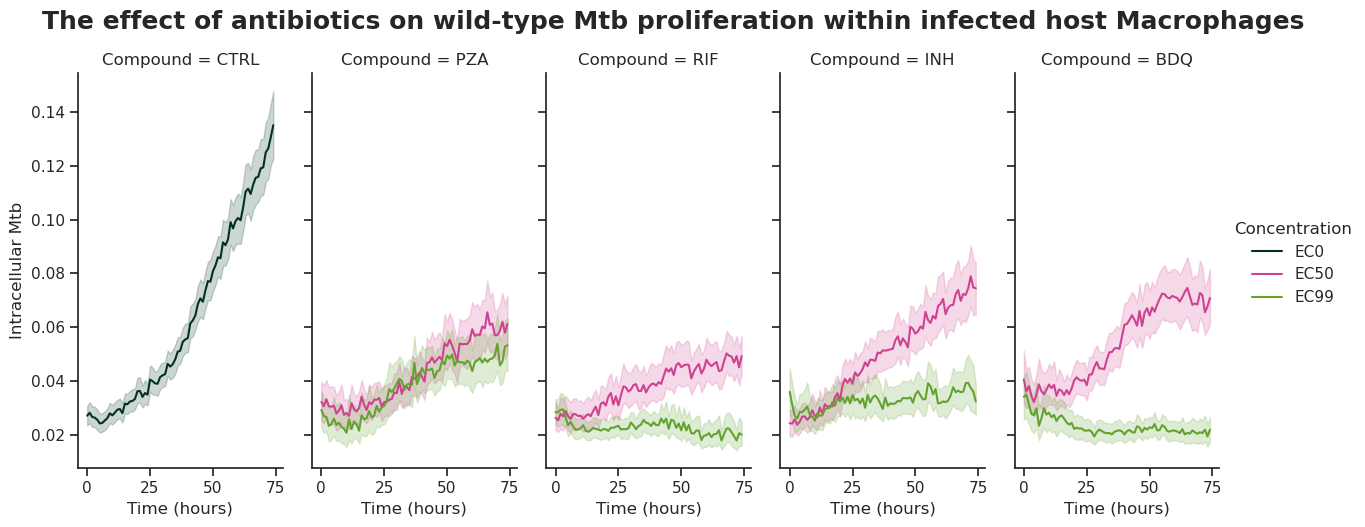

In [149]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') & (df['Infection status'] == 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within infected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_infected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

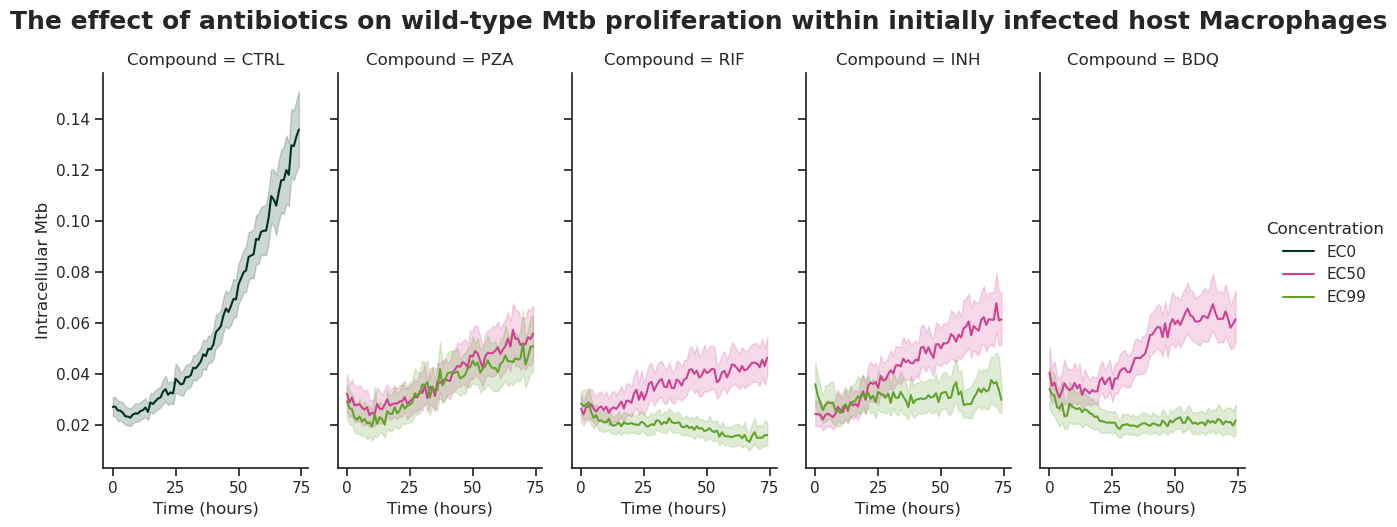

In [163]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') & (df['Initial infection status'] == 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within initially infected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_initially_infected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

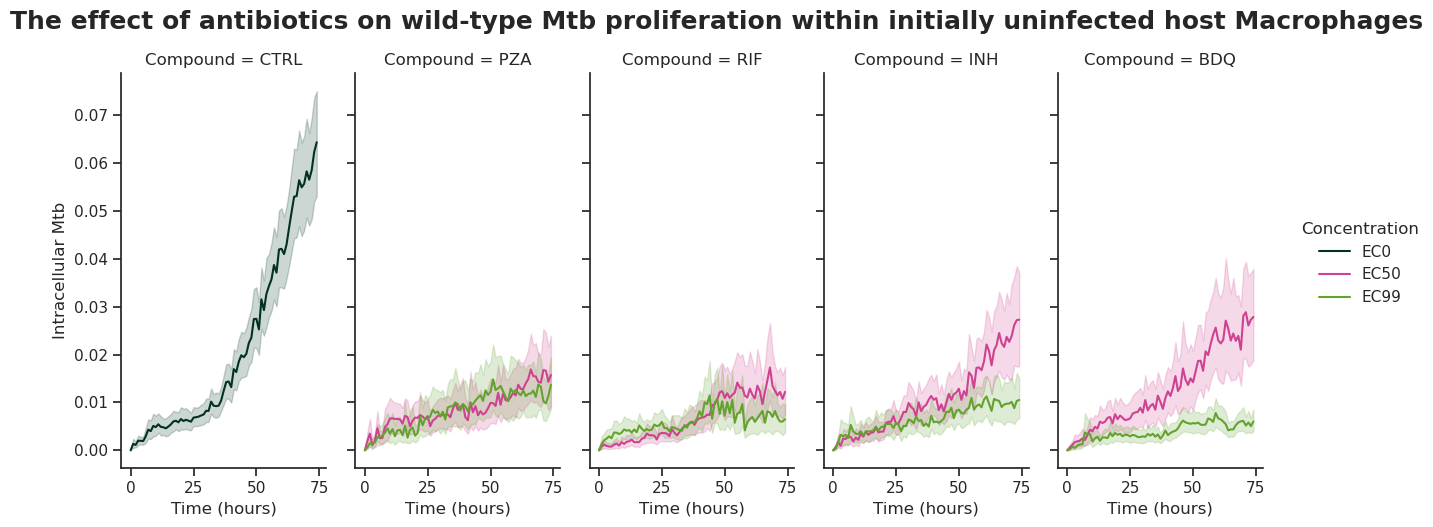

In [160]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') & (df['Initial infection status'] != 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within initially uninfected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_uninfected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

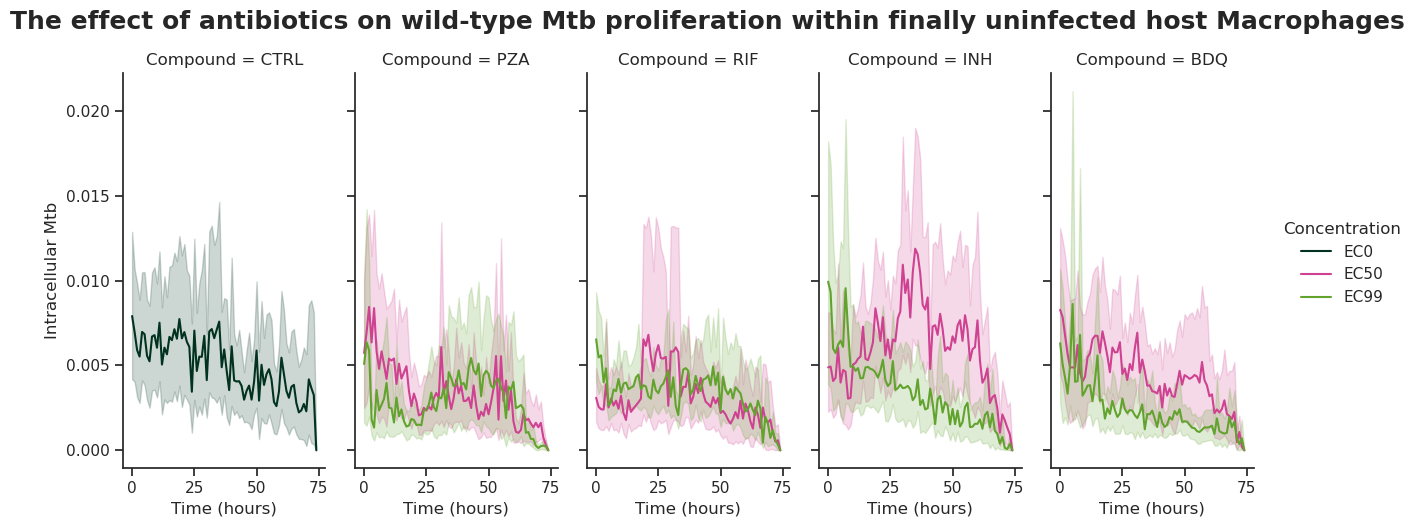

In [162]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') & (df['Final infection status'] != 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within finally uninfected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_final_uninfected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# Finding permissive cells
For each cell with infected status, what is the change in Mtb load?

In [167]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,404.540741,17.521969,2038.885334,88.310723,1.0,1.0,0.0,22641.0,354.289642,...,1192.025757,-0.027958,0.748962,0.000000,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
1,1,413.055695,10.114442,2081.800701,50.976787,1.0,1.0,0.0,11588.0,350.977905,...,1376.013428,-0.027958,0.645172,11.286093,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
2,2,382.524567,5.971316,1927.923816,30.095434,0.0,1.0,0.0,15089.0,336.285828,...,958.890137,-0.027958,0.964400,30.810960,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
3,3,387.733215,7.013307,1954.175405,35.347068,0.0,1.0,0.0,16723.0,337.263458,...,984.066406,-0.027958,0.948047,5.311851,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
4,4,397.491516,8.356998,2003.357241,42.119272,0.0,1.0,0.0,24029.0,337.026093,...,1016.706482,-0.027958,0.951076,9.850378,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452417,70,740.603149,275.762604,3732.639873,1389.843523,1.0,0.0,0.0,104937.0,363.433960,...,1183.976929,0.000000,0.797845,1.546608,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452418,71,742.959290,295.042786,3744.514819,1487.015640,1.0,0.0,0.0,59328.0,360.162720,...,1099.063599,0.000000,0.497413,19.423615,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452419,72,743.820374,298.072815,3748.854683,1502.286987,1.0,0.0,0.0,71791.0,365.228577,...,1428.077393,0.000000,0.820148,3.150007,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452420,73,744.693665,296.888824,3753.256069,1496.319675,0.0,0.0,0.0,66184.0,358.656128,...,1097.713745,0.000000,0.592617,1.471214,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9


In [168]:
df[df['Acquisition ID'] == (3, 5)]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17492,0,1008.717163,13.787997,5083.934502,69.491506,0.0,0.0,1.0,16539.0,370.667145,...,2102.166992,0.296730,0.321036,0.000000,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17493,1,1017.692261,13.876625,5129.168994,69.938190,0.0,0.0,1.0,21793.0,366.863525,...,1943.650757,0.296730,0.693013,8.975535,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17494,2,1010.612000,22.133427,5093.484478,111.552470,0.0,0.0,1.0,30076.0,370.363007,...,1980.671875,0.296730,0.856426,10.876804,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17495,3,1017.980957,17.815887,5130.624023,89.792073,0.0,0.0,1.0,38735.0,364.974091,...,1595.770264,0.296730,0.490744,8.540649,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17496,4,1019.862122,18.439526,5140.105093,92.935209,NaN,0.0,1.0,NaN,NaN,...,NaN,0.296730,NaN,1.981844,WT,CTRL,EC0,328,"(3, 5)",328.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37236,70,322.268707,900.090271,1624.234285,4536.454966,1.0,0.0,1.0,13949.0,384.735260,...,4074.046143,0.013989,0.690332,4.665771,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37237,71,324.858215,898.744812,1637.285405,4529.673853,1.0,0.0,1.0,17539.0,390.415070,...,3860.458008,0.013989,0.657098,2.918186,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37238,72,323.491119,897.620728,1630.395242,4524.008467,1.0,0.0,1.0,18053.0,388.542084,...,3558.143799,0.013989,0.737329,1.769892,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37239,73,320.940338,900.301575,1617.539304,4537.519937,1.0,0.0,1.0,16371.0,386.326538,...,3878.449219,0.013989,0.623358,3.700463,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5


In [174]:
df[(df['delta Mtb'] == 0) & (df['Acquisition ID'] == (3, 5))]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17862,0,869.708252,51.315140,4383.329590,258.628304,0.0,0.0,0.0,10651.0,365.507935,...,3221.545654,0.0,0.753992,0.000000,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17863,1,869.894836,52.680153,4384.269976,265.507971,0.0,0.0,0.0,10349.0,367.487885,...,3805.524658,0.0,0.473193,1.377706,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17864,2,870.150330,53.819511,4385.557661,271.250338,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,1.167653,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17865,3,879.969482,51.205158,4435.046191,258.073997,0.0,0.0,0.0,14162.0,364.665863,...,3020.734619,0.0,0.719241,10.161230,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17866,4,882.416687,55.292709,4447.380103,278.675255,0.0,0.0,0.0,10679.0,368.641449,...,3397.134277,0.0,0.624803,4.764125,WT,CTRL,EC0,314,"(3, 5)",314.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36989,70,548.385254,1080.732300,2763.861680,5446.890791,0.0,0.0,0.0,79991.0,373.346924,...,2059.243408,0.0,0.795766,1.875342,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36990,71,542.582886,1073.401978,2734.617744,5409.945967,1.0,0.0,0.0,96171.0,404.606873,...,2592.448730,0.0,0.584959,9.348856,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36991,72,542.676147,1080.964600,2735.087783,5448.061582,0.0,0.0,0.0,72327.0,373.303864,...,2216.799072,0.0,0.775983,7.563197,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36992,73,544.904968,1081.448608,2746.321040,5450.500986,0.0,0.0,0.0,72763.0,373.604675,...,2245.941895,0.0,0.775448,2.280769,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5


In [180]:
df[(df['delta Mtb'] < 0) & (df['Acquisition ID'] == (3, 5))]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17702,0,53.351444,32.730335,268.891279,164.960890,1.0,1.0,0.0,40790.0,345.023102,...,1509.615601,-0.000637,0.891169,0.000000,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17703,1,56.193974,34.384975,283.217627,173.300276,1.0,1.0,0.0,37799.0,347.174042,...,1531.016724,-0.000637,0.900712,3.289043,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17704,2,55.384895,29.955753,279.139872,150.976997,1.0,1.0,0.0,45476.0,345.375885,...,1262.655762,-0.000637,0.872722,4.502512,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17705,3,61.899239,24.086212,311.972162,121.394509,1.0,1.0,0.0,70278.0,344.313843,...,1190.980957,-0.000637,0.751798,8.768591,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17706,4,54.777966,30.044285,276.080946,151.423195,1.0,1.0,0.0,42413.0,346.258698,...,1336.886719,-0.000637,0.872993,9.284996,WT,CTRL,EC0,323,"(3, 5)",323.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37166,70,453.127197,414.424225,2283.761074,2088.698093,1.0,1.0,0.0,98049.0,363.043701,...,1490.671997,-0.015679,0.853023,0.584299,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37167,71,452.274658,412.528046,2279.464277,2079.141350,1.0,1.0,0.0,94502.0,360.016998,...,1360.443848,-0.015679,0.843933,2.079019,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37168,72,450.470154,414.157043,2270.369575,2087.351499,1.0,1.0,0.0,102749.0,356.613739,...,1321.010010,-0.015679,0.833678,2.431022,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37169,73,450.650635,416.058044,2271.279199,2096.932544,1.0,1.0,0.0,107937.0,356.725128,...,1191.234863,-0.015679,0.832807,1.909549,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5


In [ ]:
plt.hist()

In [ ]:
for cell_ID in set(expt_49['Cell ID'].values):
    mtb_content = expt_49[expt_49['Cell ID'] == cell_ID]['Intracellular Mtb content']
    mean_mtb_content = np.nanmean(mtb_content)
    mtb_range = mtb_content.max() - mtb_content.min()
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mean Mtb content'] = mean_mtb_content
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mtb content range'] = mtb_range

# Adding single-cell measures

Text(0.5, 1.08, 'The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages')

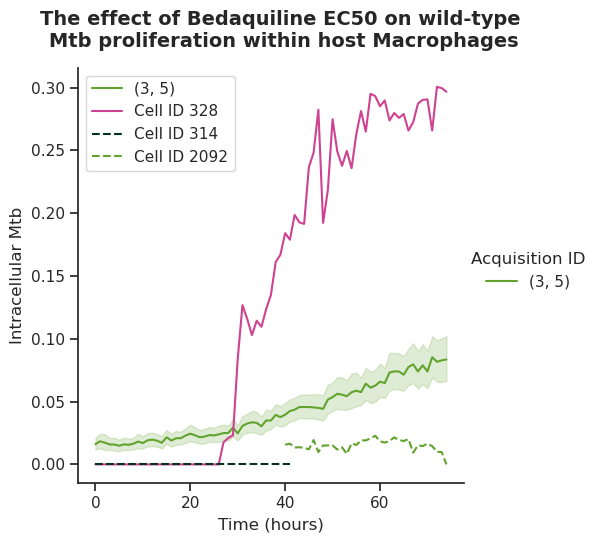

In [183]:
g = sns.relplot(data = df[(df['Acquisition ID'] == (3, 5))], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,

            palette=[colors[-1]],                 
           )
sns.lineplot(x = df[df['Unique ID'] == '328.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '328.3.5']['Intracellular thresholded Mtb content'], 
            label = 'Cell ID 328', linestyle='-', color = colors[1])
sns.lineplot(x = df[df['Unique ID'] == '314.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '314.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 314', linestyle='--', color = colors[0])
sns.lineplot(x = df[df['Unique ID'] == '2092.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '2092.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 2092', linestyle='--', color = colors[2])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

Text(0.5, 1.08, 'The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages')

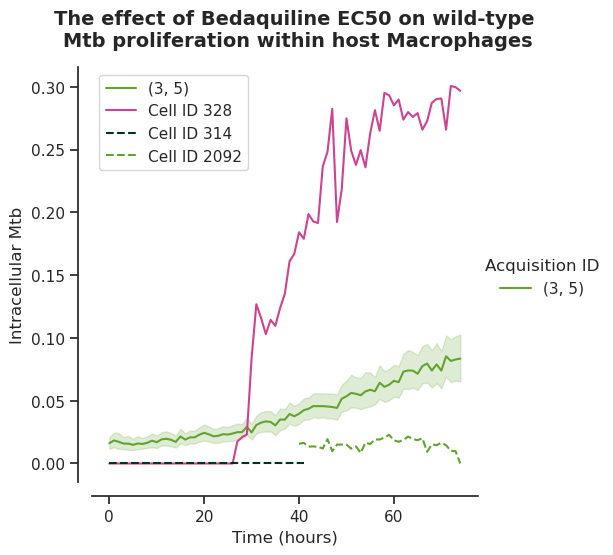

In [184]:
g = sns.relplot(data = df[(df['Acquisition ID'] == (3, 5))], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,

            palette=[colors[-1]],                 
           )
sns.lineplot(x = df[df['Unique ID'] == '328.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '328.3.5']['Intracellular thresholded Mtb content'], 
            label = 'Cell ID 328', linestyle='-', color = colors[1])
sns.lineplot(x = df[df['Unique ID'] == '314.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '314.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 314', linestyle='--', color = colors[0])
sns.lineplot(x = df[df['Unique ID'] == '2092.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '2092.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 2092', linestyle='--', color = colors[2])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
sns.despine(offset=10)
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

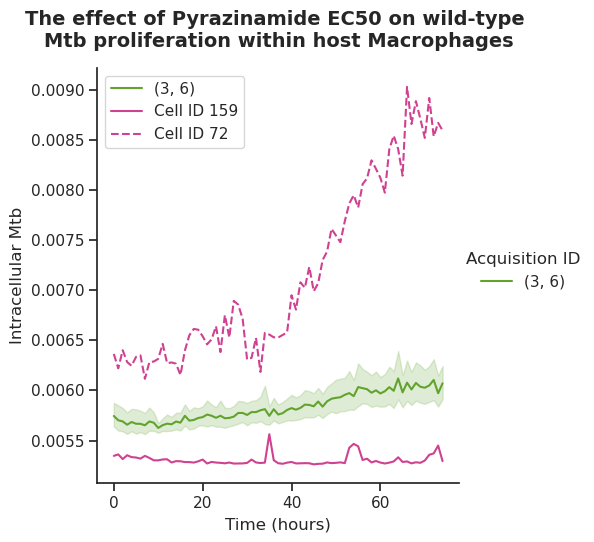

In [194]:
expt = df[(df['Acquisition ID'] == (3, 6))]

g = sns.relplot(data = expt, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[-1]],                 
           )

sns.lineplot(x = expt[expt['Cell ID'] == 159]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 159]['Intracellular Mtb content'], 
            label = 'Cell ID 159', linestyle='-', color = colors[1])
sns.lineplot(x = expt[expt['Cell ID'] == 72]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 72]['Intracellular Mtb content'],
             label = 'Cell ID 72', linestyle='--', color = colors[1])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Pyrazinamide EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/PZA_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

In [172]:
expt_49[expt_49['Cell ID'] == 17]

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Mean Mtb content,Mtb content range
175359,0,787.419189,841.815674,2376.0,0.005280,0.018034,0.876459,0.000000,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175360,1,792.964844,841.721985,2248.0,0.005311,0.023384,0.883034,5.546446,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175361,2,794.169678,845.634888,2487.0,0.005290,0.022281,0.858829,4.094195,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175362,3,794.383545,844.478271,2902.0,0.005278,0.020764,0.867945,1.176223,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175363,4,793.184143,845.630737,2911.0,0.005294,0.021835,0.858054,1.663353,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175429,70,802.580017,847.569946,2967.0,0.005287,0.027800,0.768146,0.856586,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175430,71,798.543762,851.178406,2685.0,0.005307,0.030774,0.778602,5.414087,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175431,72,801.885193,850.783386,3379.0,0.005286,0.026049,0.710469,3.364699,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175432,73,800.708435,854.149414,3286.0,0.005287,0.023522,0.581367,3.565796,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148


## Iterating over each expt compound cond

In [159]:
antibiotic_dict = {
    "CTRL": "Control",
    "PZA": "Pyrazinamide",
    "RIF": "Rifampicin",
    "INH": "Isoniazid",
    "BDQ": "Bedaquiline"
}


In [157]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    print(compound)

CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ


In [162]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    if compound == 'CTRL':
        continue
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
   
    g.set_ylabels("Intracellular Mtb")
    
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
    
    g.set_ylabels("Intracellular Mtb")
   
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound) &
                   (df['Concentration'] == 'EC50')
                             ], 

                x = 'Time (hours)', 
                y = 'Intracellular Mtb content', 
                style= 'Acquisition ID',
                hue= 'Acquisition ID',
    #             col= 'Compound',
                kind = 'line',
                aspect = 1,
                palette=[colors[1], colors[-1]]
               )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} EC50 on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_EC50_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>